In [1]:
cd drive/MyDrive/Maskrcnn

/content/drive/MyDrive/Maskrcnn


In [2]:
import os
import json
import torch
from PIL import Image
import skimage.color
import skimage.io
import skimage.transform
import numpy as np

In [3]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
from torch.optim.lr_scheduler import StepLR

In [4]:
from engine import train_one_epoch, evaluate
import utils
import transforms as T

In [5]:
class BalloonDataset(torch.utils.data.Dataset):
  def __init__(self, root, transforms=None):
    self.root = root
    self.transforms = transforms
    self.images = list(sorted(os.listdir(os.path.join(root, "images"))))
    self.polygon_path = os.path.join(root, "via_region_data.json")

    self.load_images()

  def __getitem__(self, idx):
    img_path = os.path.join(self.root, "images", self.image_info[idx]["image_id"])
    img = Image.open(img_path).convert("RGB")

    # 함수 이용해서 numpy attributes 생성
    masks, num_objs, boxes = self.make_mask_box(idx)

    # torch.Tensor 형식으로 변환
    boxes = torch.as_tensor(boxes, dtype=torch.float32)
    # there is only one class
    labels = torch.ones((num_objs,), dtype=torch.int64)
    masks = torch.as_tensor(masks, dtype=torch.uint8)
    image_id = torch.tensor([idx])
    area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
    # suppose all instances are not crowd
    iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

    target = {}
    target["boxes"] = boxes
    target["labels"] = labels
    target["masks"] = masks
    target["image_id"] = image_id
    target["area"] = area
    target["iscrowd"] = iscrowd

    if self.transforms is not None:
      img, target = self.transforms(img, target)

    return img, target
  
  def __len__(self):
    return len(self.images)

  def load_images(self):
    self.annotations = json.load(open(self.polygon_path))
    self.annotations = list(self.annotations.values())
    self.annotations = [a for a in self.annotations if a['regions']]

    self.image_info = []

    for a in self.annotations:
      polygons = [r['shape_attributes'] for r in a['regions'].values()]

      # load_mask() needs the image size to convert polygons to masks.
      # Unfortunately, VIA doesn't include it in JSON, so we must read
      # the image. This is only managable since the dataset is tiny.
      image_path = os.path.join(self.root, "images/"+a['filename'])
      image = skimage.io.imread(image_path)
      height, width = image.shape[:2]

      self.image_info.append({"image_id" : a['filename'], 
                             "path": image_path,
                             "width" : width,
                             "height" : height,
                             "polygons" : polygons})


  def make_mask_box(self, idx):
    masks = []
    num_objs = 0
    boxes = []

    info = self.image_info[idx]
    for i, p in enumerate(info["polygons"]):
      mask = np.zeros(([info["height"], info["width"]]), dtype=np.uint8)
      rr, cc = skimage.draw.polygon(p['all_points_y'], p['all_points_x'])

      length = len(rr)
      for i in range(length):
        if rr[i] < info["height"] and cc[i] <info["width"]:
          mask[rr[i], cc[i]] = 1

      x_coordinates, y_coordinates = p['all_points_x'], p['all_points_y']
      box = [min(x_coordinates), min(y_coordinates), max(x_coordinates), max(y_coordinates)]
      
      num_objs += 1

      masks.append(mask)
      boxes.append(box)

    return masks, num_objs, boxes

In [6]:
def get_model_instance_segmentation(num_classes):
    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)

    # get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask, hidden_layer, num_classes)

    return model

In [7]:
def get_transform(train):
    transforms = []
    # converts the image, a PIL image, into a PyTorch Tensor
    transforms.append(T.ToTensor())
    if train:
        # during training, randomly flip the training images and ground-truth for data augmentation
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

In [8]:
# use our dataset and defined transformations
dataset = BalloonDataset('balloon_dataset/train', get_transform(train=True))
dataset_test = BalloonDataset('balloon_dataset/val', get_transform(train=True))

# split the dataset in train and test set
torch.manual_seed(1)
indices = torch.randperm(len(dataset)).tolist()
# dataset = torch.utils.data.Subset(dataset, indices[:-50])
# dataset_test = torch.utils.data.Subset(dataset_test, indices[-50:])

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(dataset, batch_size=2, shuffle=True, num_workers=4,collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(dataset_test, batch_size=1, shuffle=False, num_workers=4,collate_fn=utils.collate_fn)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [9]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# our dataset has two classes only - background and person
num_classes = 2

# get the model using our helper function
model = get_model_instance_segmentation(num_classes)
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

# and a learning rate scheduler which decreases the learning rate by 1/10 every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=MaskRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=MaskRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [10]:
#  from engine import train_one_epoch, evaluate

num_epochs = 10

for epoch in range(num_epochs):

    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    lr_scheduler.step()   
    evaluate(model, data_loader_test, device=device)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin

Epoch: [0]  [ 0/31]  eta: 0:05:45  lr: 0.000171  loss: 18.1051 (18.1051)  loss_classifier: 0.5298 (0.5298)  loss_box_reg: 0.1640 (0.1640)  loss_mask: 17.4077 (17.4077)  loss_objectness: 0.0031 (0.0031)  loss_rpn_box_reg: 0.0004 (0.0004)  time: 11.1350  data: 5.6604  max mem: 2397


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)


Epoch: [0]  [10/31]  eta: 0:01:09  lr: 0.001836  loss: 1.6105 (4.9153)  loss_classifier: 0.3376 (0.3624)  loss_box_reg: 0.2137 (0.2796)  loss_mask: 0.9854 (4.1513)  loss_objectness: 0.0434 (0.1127)  loss_rpn_box_reg: 0.0048 (0.0093)  time: 3.3214  data: 2.2690  max mem: 3399
Epoch: [0]  [20/31]  eta: 0:00:33  lr: 0.003501  loss: 1.3346 (3.1471)  loss_classifier: 0.2946 (0.3147)  loss_box_reg: 0.2767 (0.3097)  loss_mask: 0.6375 (2.4148)  loss_objectness: 0.0625 (0.0926)  loss_rpn_box_reg: 0.0107 (0.0153)  time: 2.6309  data: 1.9727  max mem: 3797
Epoch: [0]  [30/31]  eta: 0:00:02  lr: 0.005000  loss: 1.2513 (2.5072)  loss_classifier: 0.2241 (0.2936)  loss_box_reg: 0.3597 (0.3472)  loss_mask: 0.4248 (1.7774)  loss_objectness: 0.0431 (0.0739)  loss_rpn_box_reg: 0.0105 (0.0152)  time: 2.3781  data: 1.6932  max mem: 3797
Epoch: [0] Total time: 0:01:24 (2.7162 s / it)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)


creating index...
index created!
Test:  [ 0/13]  eta: 0:01:57  model_time: 2.3464 (2.3464)  evaluator_time: 4.0697 (4.0697)  time: 9.0174  data: 2.5740  max mem: 3797
Test:  [12/13]  eta: 0:00:02  model_time: 0.2541 (0.5606)  evaluator_time: 0.2883 (0.9272)  time: 2.1884  data: 0.6819  max mem: 3797
Test: Total time: 0:00:28 (2.1984 s / it)
Averaged stats: model_time: 0.2541 (0.5606)  evaluator_time: 0.2883 (0.9272)
Accumulating evaluation results...
DONE (t=0.01s).
Accumulating evaluation results...
DONE (t=0.01s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.036
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.085
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.021
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | max

In [11]:
# pick one image from the test set
img, _ = dataset_test[1]
# put the model in evaluation mode
model.eval()
with torch.no_grad():
    prediction = model([img.to(device)])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


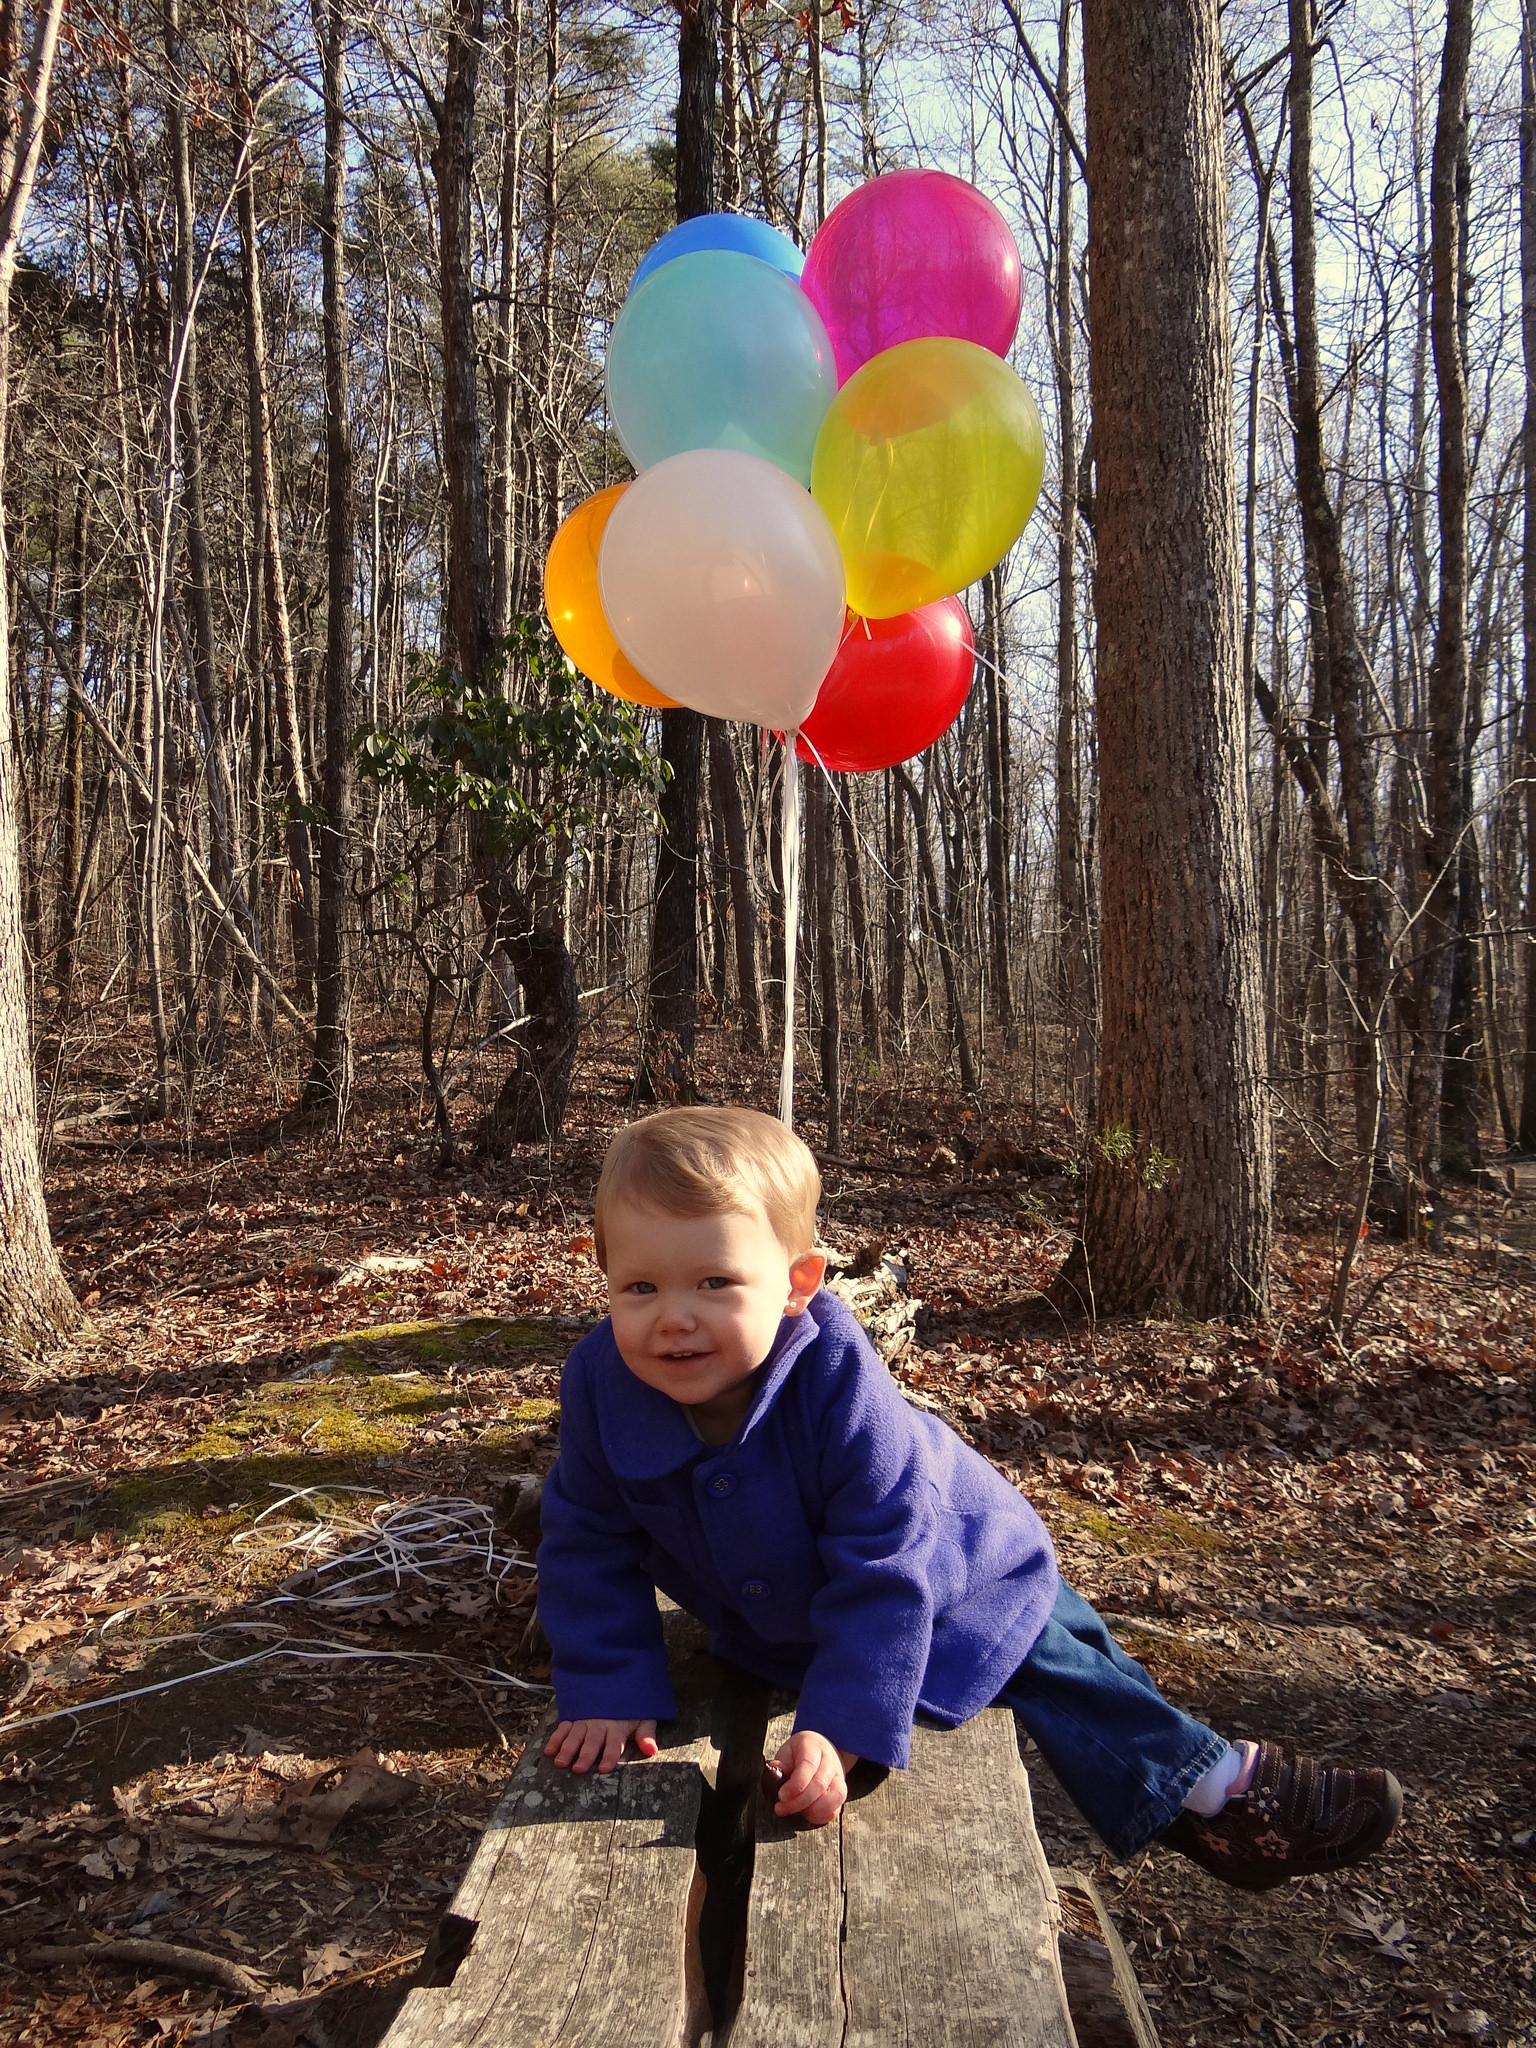

In [12]:
Image.fromarray(img.mul(255).permute(1, 2, 0).byte().numpy())

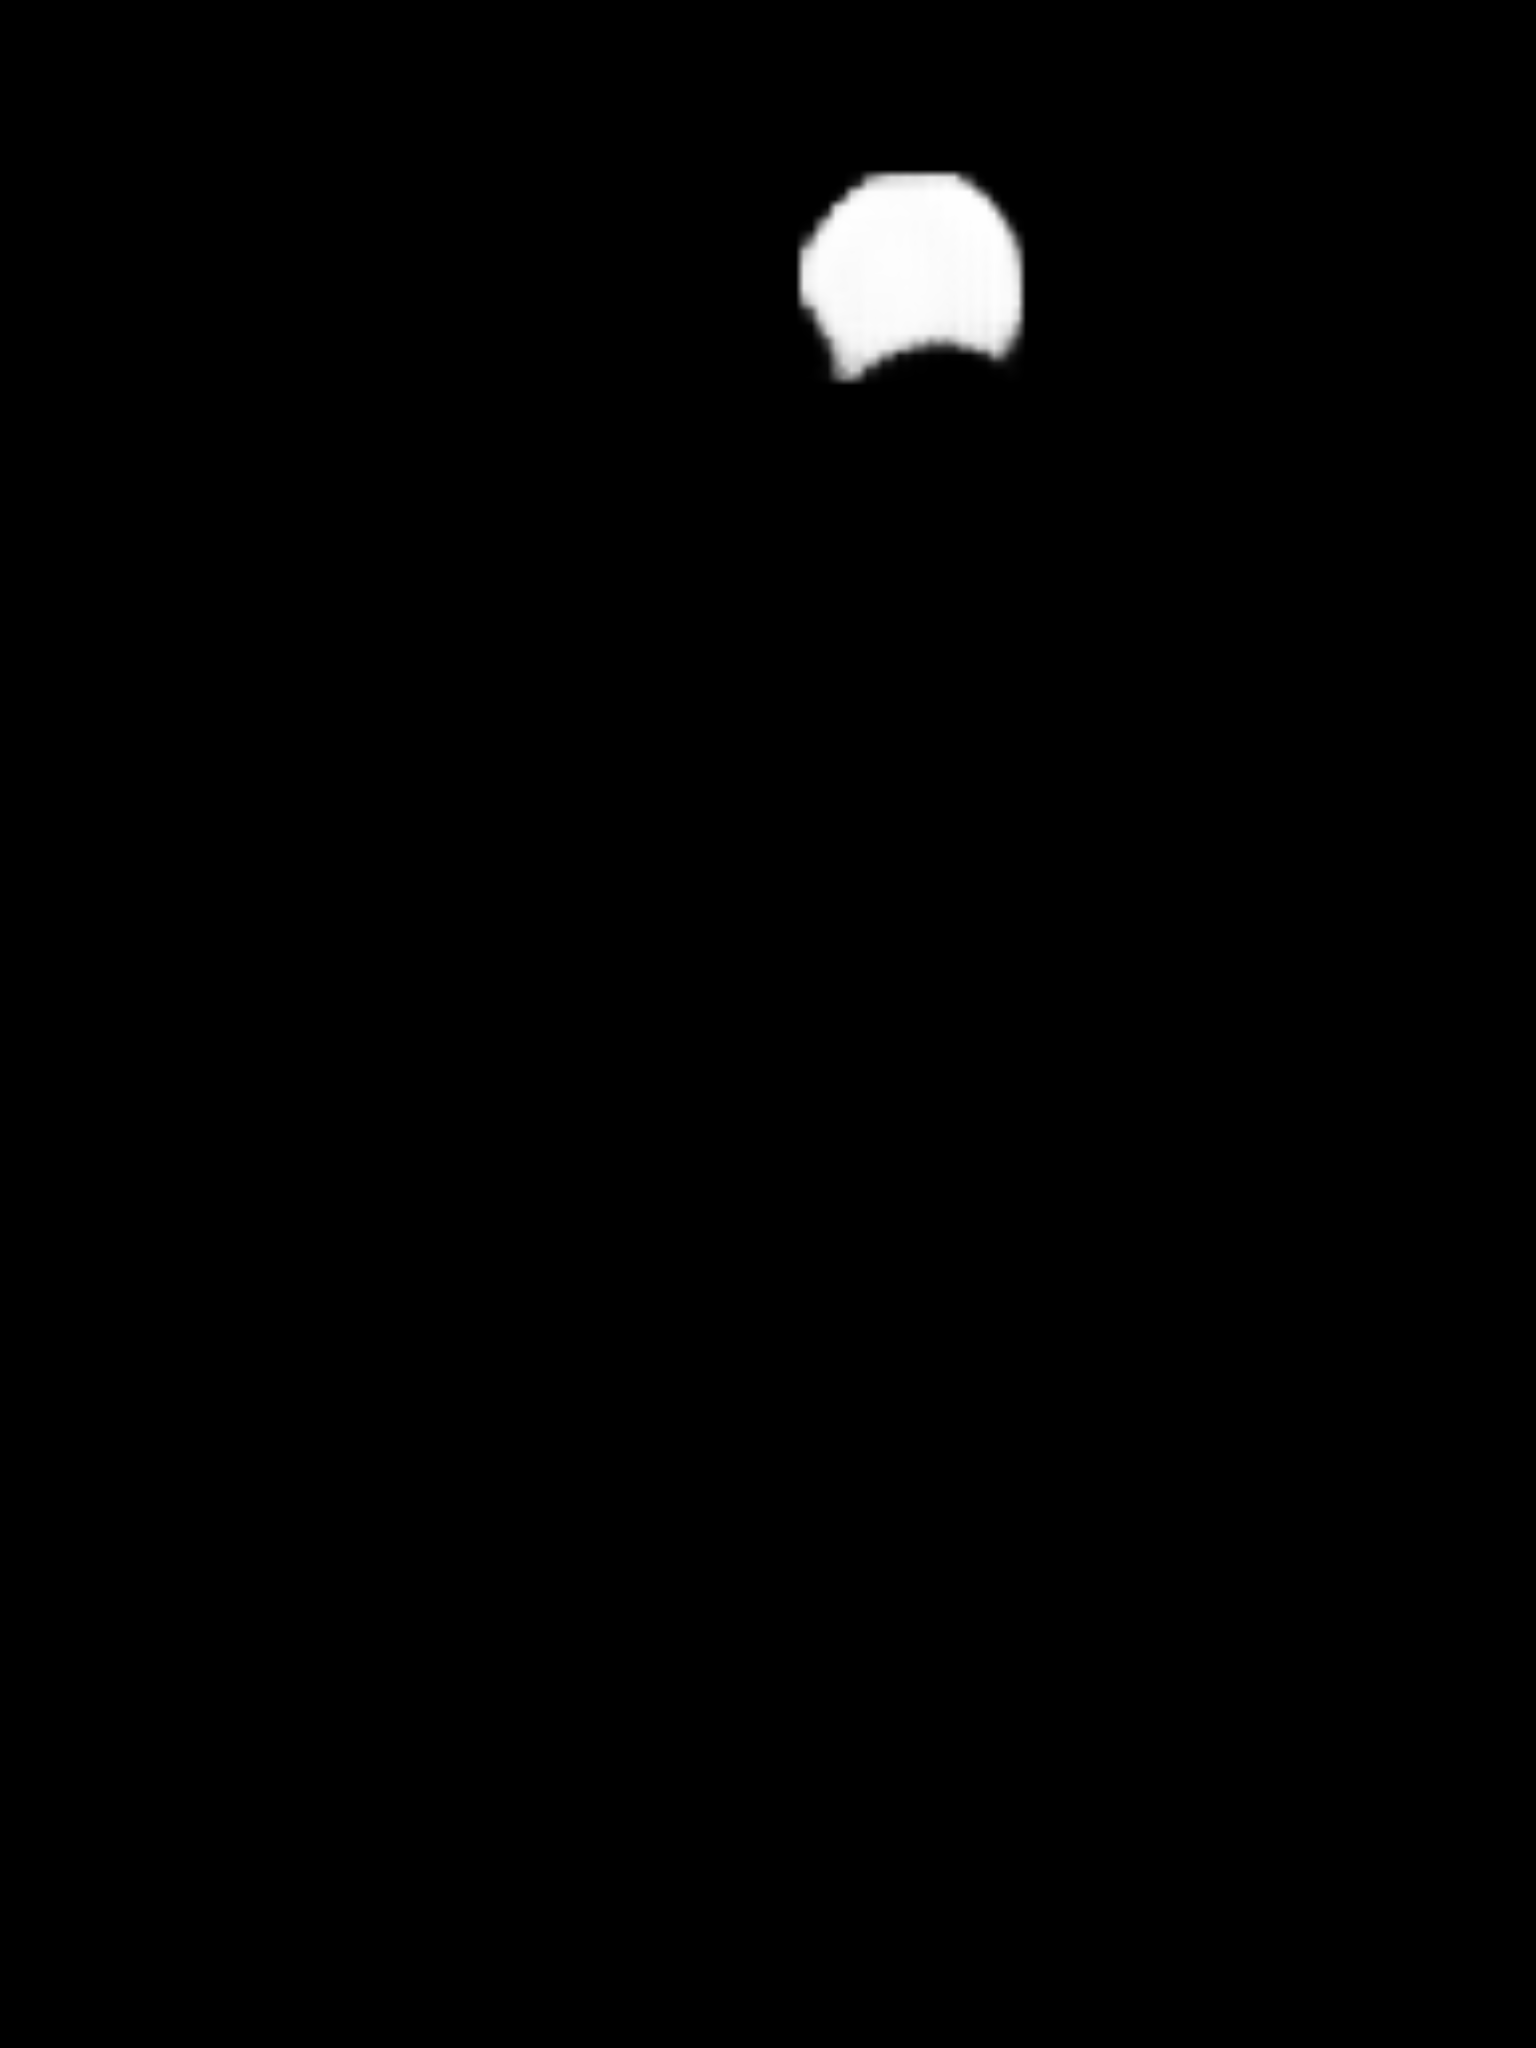

In [13]:
Image.fromarray(prediction[0]['masks'][0, 0].mul(255).byte().cpu().numpy())

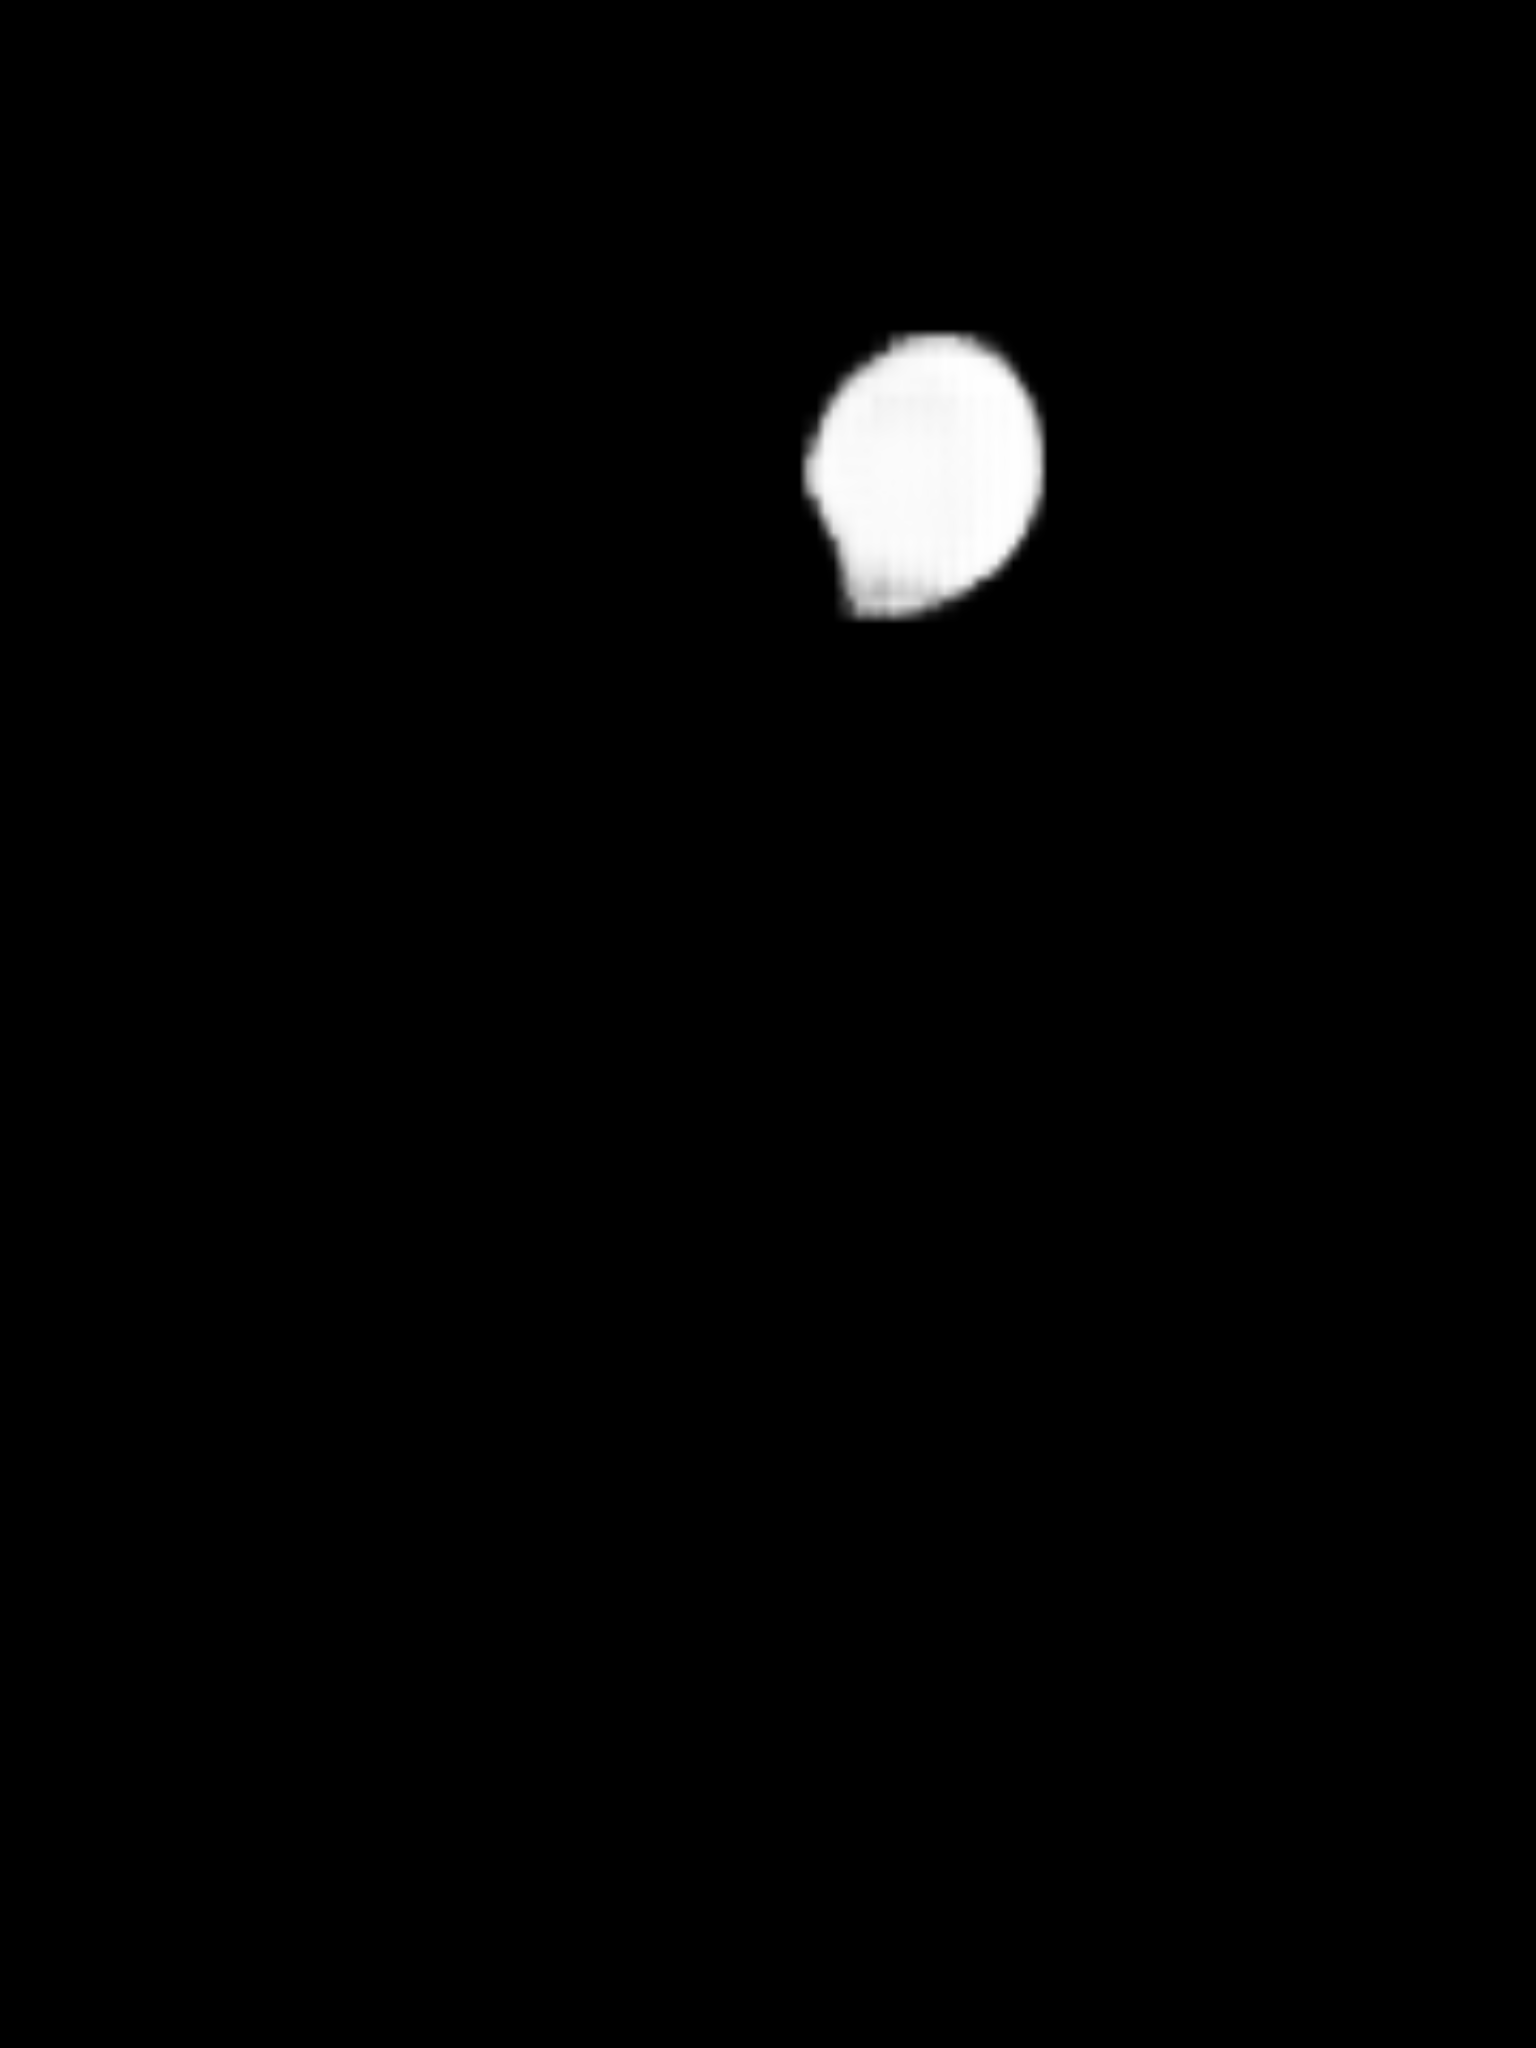

In [14]:
Image.fromarray(prediction[0]['masks'][1, 0].mul(255).byte().cpu().numpy())

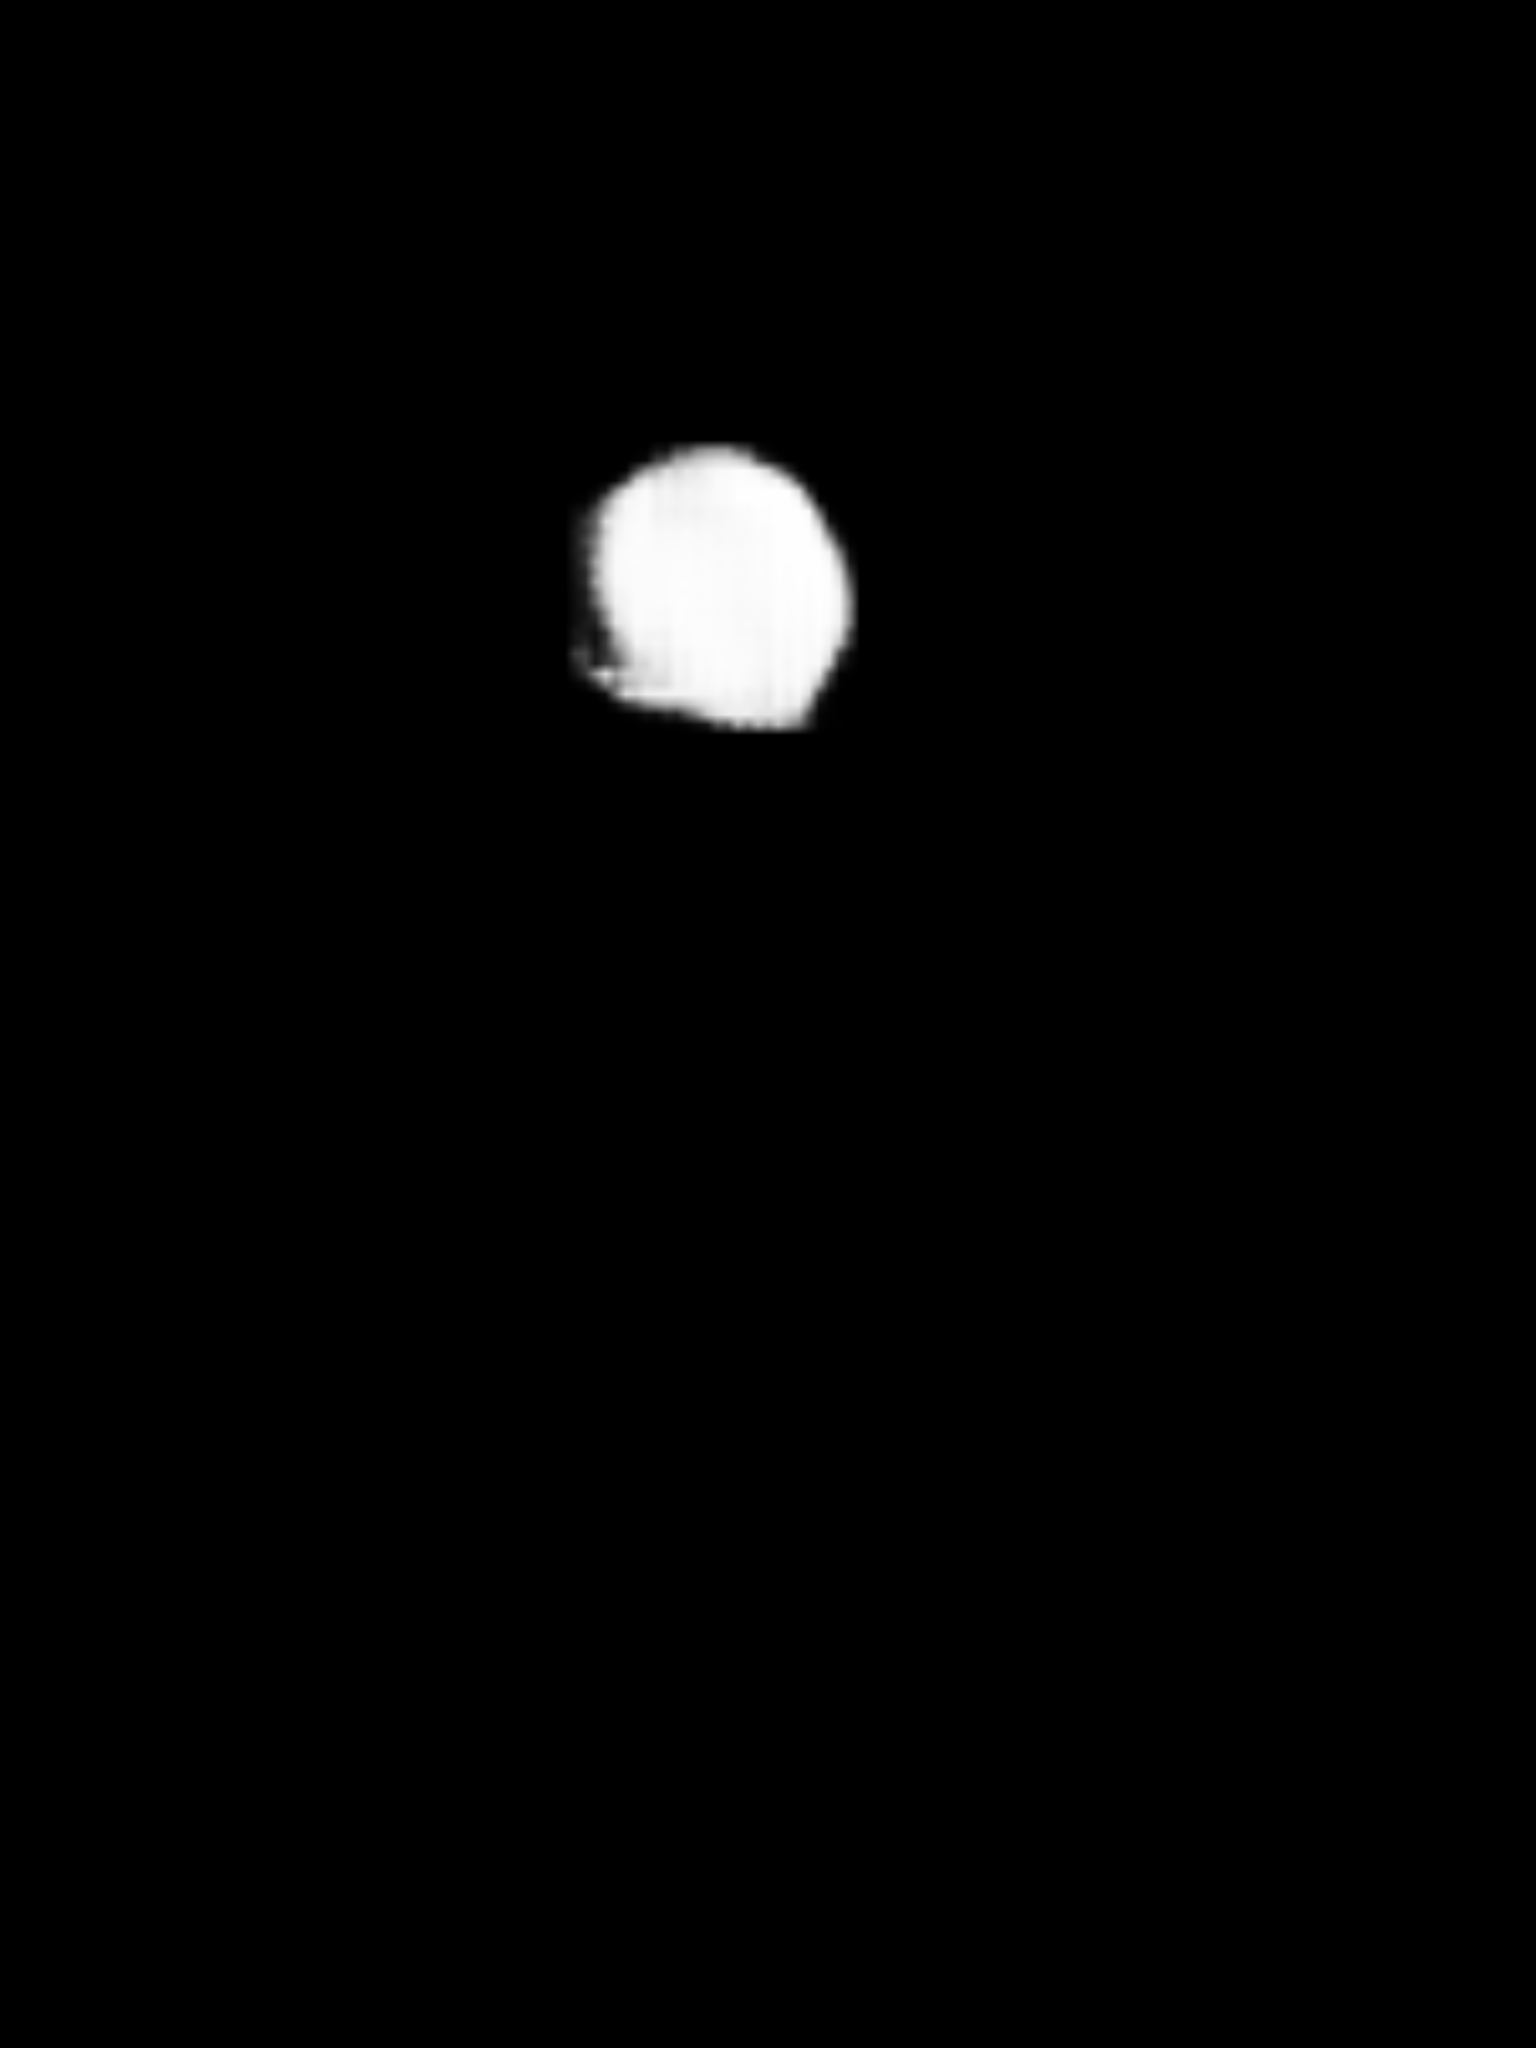

In [15]:
Image.fromarray(prediction[0]['masks'][2, 0].mul(255).byte().cpu().numpy())